In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2
%load_ext rmagic
%pylab inline

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic
Populating the interactive namespace from numpy and matplotlib


## Visualization of the Cars Dataset

In [3]:
df = pd.read_csv('data/cars_multivariate.csv', na_values=['?'] )
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15,8,350,165,3693,11.5,70,1,buick skylark 320
2,18,8,318,150,3436,11.0,70,1,plymouth satellite
3,16,8,304,150,3433,12.0,70,1,amc rebel sst
4,17,8,302,140,3449,10.5,70,1,ford torino


### Make sure nominal/ordinal variables are interpretable

In [7]:
# Origin
df['Origin'] = df.origin.astype('category')
df.Origin.cat.categories = ['USA', 'Japan', 'Europe']

# Cylinders
df['Cylinders'] = df.cylinders.astype(str) + '-cylinder'

# Model
df['Model'] = df.model + 1900
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name,Origin,Cylinders,Model
0,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu,USA,8-cylinder,1970
1,15,8,350,165,3693,11.5,70,1,buick skylark 320,USA,8-cylinder,1970
2,18,8,318,150,3436,11.0,70,1,plymouth satellite,USA,8-cylinder,1970
3,16,8,304,150,3433,12.0,70,1,amc rebel sst,USA,8-cylinder,1970
4,17,8,302,140,3449,10.5,70,1,ford torino,USA,8-cylinder,1970


### GGPlot is your best bet for high-dimensional visual encodings
- GGPlot implements a _Grammar of Graphics_ (http://vita.had.co.nz/papers/layered-grammar.pdf)
- Still way behind the original R implementation
- We only teach you one tool, but you should learn many!!!

In [8]:
from ggplot import *

### Examine MPG as dependent variable

In [17]:
df.Cylinders.value_counts()

4-cylinder    204
8-cylinder    103
6-cylinder     84
3-cylinder      4
5-cylinder      3
dtype: int64

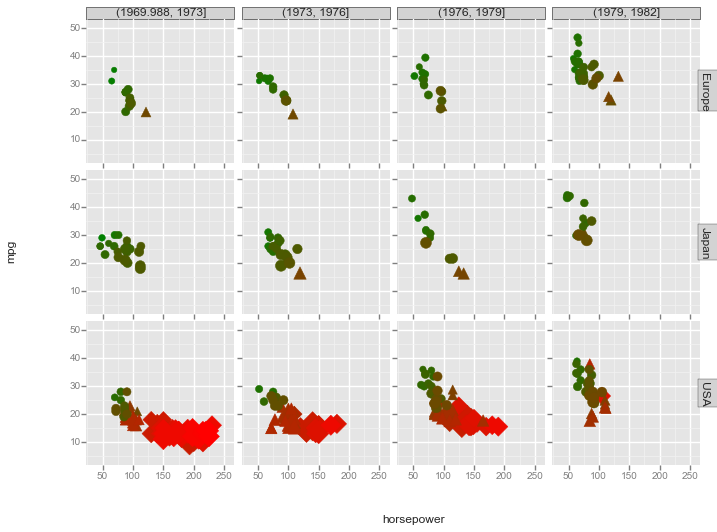

<ggplot: (292269605)>

In [36]:
# Remove 3 and 5 cylinders
temp = df.copy()
temp = temp.loc[temp.cylinders.isin([4,6,8])]

# Discretize model year
temp['Era'] = pd.cut(temp.Model, 4)

# Scale displacement
temp['Displacement'] = np.log(temp.displacement)

# Discretize acceleration into above median and below median
temp['Acceleration'] = pd.cut(temp.acceleration, 2)

p = ggplot(aes(x = 'horsepower', y = 'mpg', color = 'Displacement', shape = 'Cylinders', size = 'weight'),
           data = temp)
p + geom_point() + facet_grid(x='Origin', y='Era') + scale_color_gradient(low='green', high='red')

### Or, in R
- http://rpy.sourceforge.net/rpy2/doc-2.4/html/index.html
- requires installation of R

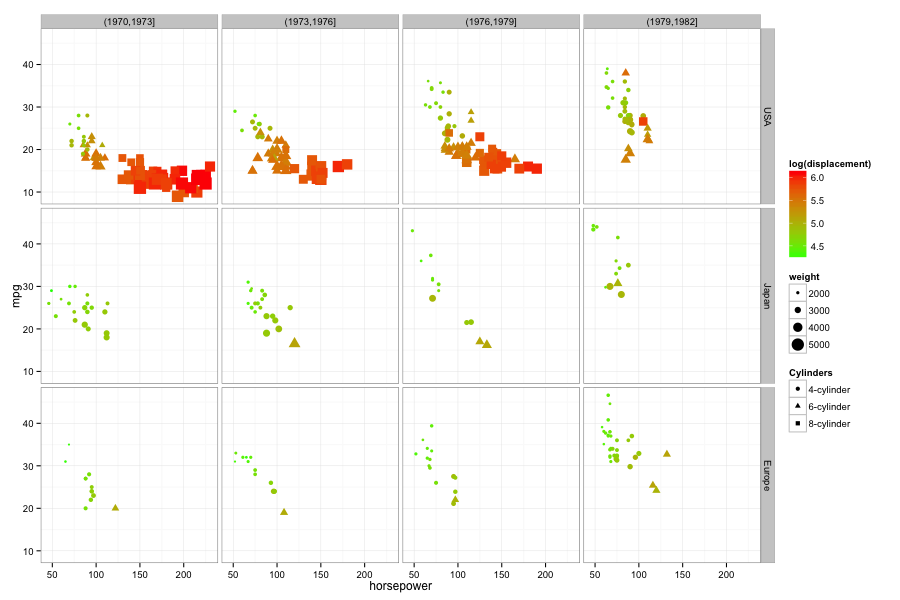

In [44]:
%%R -w 900 -h 600

library(ggplot2)
library(reshape2)
library(plyr)

# Load the data
df = read.csv('data/cars_multivariate.csv',na.strings = c('?'))
head(df)

# Plotting df
temp = df
temp = temp[temp$cylinders %in% c(4,6,8),]

# Process
temp$model <- temp$model + 1900
temp$Era = cut(temp$model, 4)
# temp$Acceleration = cut(temp$acceleration, 2)
temp$Cylinders = paste0(temp$cylinders, '-cylinder')
temp$Origin <- factor(temp$origin, labels=c('USA', 'Japan', 'Europe'))

# Plot
p = ggplot(temp, aes(x = horsepower, 
                     y = mpg, 
                     size = weight,
                     color = log(displacement),
                     shape = Cylinders)) +
  geom_point() +
  scale_color_gradient(low='green', high='red') +
#   scale_size_continuous(range=c(5,10)) +
#   scale_shape_manual(values=c(95,3)) + 
  theme_bw() +
  facet_grid(Origin ~ Era)
print(p)


### Editorialize: US cars are bigger and less efficient than foreign cars
- Bar charts of Average mileage, weight, and displacement

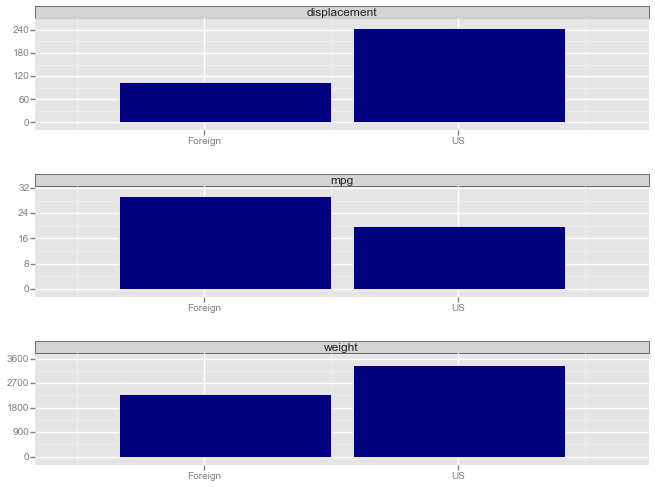

<ggplot: (289966897)>

In [74]:
# Prep the data
temp['is_us'] = (temp.Origin == 'USA').astype('category')
temp.is_us.cat.categories = ['Foreign', 'US']
temp['is_us'] = temp['is_us'].astype(str)

# Group
agg = temp.groupby('is_us')['mpg','weight','displacement'].mean().reset_index()
agg

# Melt
melted = pd.melt(agg, id_vars = ['is_us'], value_vars=['mpg','weight','displacement'])
melted

# Plot
p = ggplot(aes(x='is_us', y='value'), data=melted)
p + geom_bar(stat='identity',fill='navy') + \
    facet_grid(x='variable', scales='free') + \
    scale_x_discrete(breaks = [.6, 1.8], labels=['Foreign','US']) + \
    xlab('') + ylab('')

### R implementation has a few more features

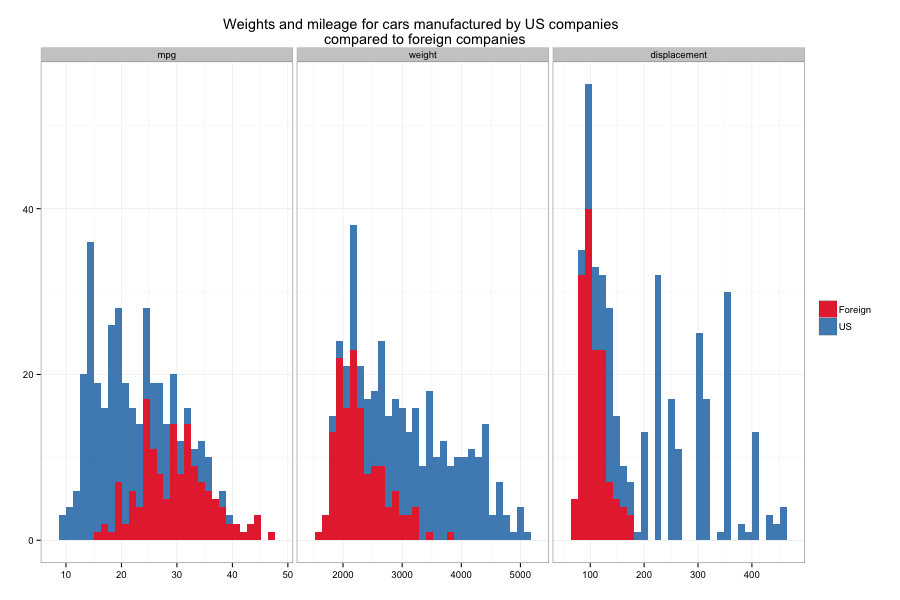

In [76]:
%%R -w 900 -h 600

# Using histograms
temp$is_us <- factor(temp$Origin == 'USA', labels = c('Foreign', 'US'))
melted <- melt(temp, id.vars=c('is_us'), measure.vars = c('mpg','weight','displacement'))
agg <- ddply(melted, .(is_us,variable), summarise,
             value = mean(value))
p <- ggplot(melted, aes(x=value, fill=is_us)) +
  geom_histogram(alpha=.9) +
  scale_fill_brewer(palette='Set1', name='') +
  theme_bw() +
  xlab('') +
  ylab('') +
  facet_grid(.~variable, scales='free') + 
  ggtitle('Weights and mileage for cars manufactured by US companies \n compared to foreign companies')
print(p)


### Matplotlib

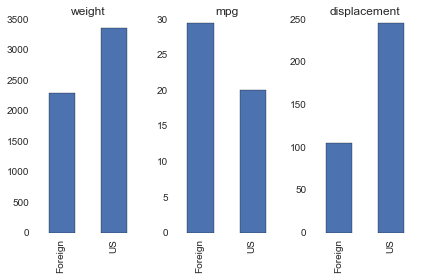

In [80]:
fig, ax = plt.subplots(1,3)
for i,v in enumerate(['weight','mpg','displacement']):
    a = ax[i]
    agg = temp.groupby('is_us')[v].mean()
    agg.plot(kind='bar', ax=a)
    a.set_title(v)
    a.set_xlabel('')
plt.tight_layout()
plt.show()